In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bps = pd.read_csv('./simdata_all_bps_comparison.csv', header=None)

In [3]:
bps.columns = ['idx','log_sp','stdev']

In [4]:
bps.head()

,idx,log_sp,stdev
0,97,3.48723,0.384700
1,715,2.87020,0.328952
2,703,2.45673,0.289775
3,24,1.91918,0.261352
4,627,1.75676,0.214797


In [5]:
bps.shape

(50, 3)

In [6]:
bps.index = bps['idx']

In [7]:
n_bins = 1000
all_bins = range(0,n_bins)

In [8]:
all_bins_df = pd.DataFrame(index=all_bins)
all_bins_df['idx'] = all_bins_df.index
all_bins_df['log_sp'] = None
all_bins_df['stdev'] = None

In [9]:
all_bins_df.head()

,idx,log_sp,stdev
0,0,None,None
1,1,None,None
2,2,None,None
3,3,None,None
4,4,None,None


In [10]:
all_bins_df.shape

(1000, 3)

In [11]:
merged_df = pd.merge(bps,all_bins_df, on=['idx'], how='outer')

In [12]:
merged_df.head()

,idx,log_sp_x,stdev_x,log_sp_y,stdev_y
0,97,3.48723,0.384700,None,None
1,715,2.87020,0.328952,None,None
2,703,2.45673,0.289775,None,None
3,24,1.91918,0.261352,None,None
4,627,1.75676,0.214797,None,None


In [13]:
merged_df = merged_df[['idx','log_sp_x','stdev_x']]
merged_df.columns = ['idx','log_sp','stdev']

In [14]:
merged_df['stdev'] = merged_df['stdev'].fillna(merged_df['stdev'].min())

In [15]:
merged_df['log_sp'] = merged_df['log_sp'].fillna(0.3)

In [16]:
bps = merged_df

## There are 2 negative log_sp values! See to it!

In [17]:
sorted(bps['log_sp'])

[-0.415984,
 -0.183974,
 0.0147541,
 0.0327589,
 0.0356893,
 0.0543001,
 0.060149400000000006,
 0.060561199999999996,
 0.07865180000000001,
 0.0819932,
 0.0836538,
 0.08367100000000001,
 0.0874202,
 0.0914928,
 0.0979878,
 0.0989995,
 0.114547,
 0.116389,
 0.126557,
 0.12753599999999998,
 0.135736,
 0.13764200000000001,
 0.14239300000000002,
 0.143544,
 0.145043,
 0.14810399999999999,
 0.153951,
 0.154014,
 0.166061,
 0.167319,
 0.17358099999999999,
 0.186638,
 0.187059,
 0.191127,
 0.202942,
 0.21844699999999997,
 0.258272,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 

In [18]:
bps.shape

(1000, 3)

In [19]:
ground_truth = pd.read_csv('./10nodes_40regions_10000reads_sim_tiny2_effective_regions.txt',header=None)
ground_truth = ground_truth[0].values.tolist()
ground_truth

[0, 12, 24, 451, 549, 627, 655, 703]

In [28]:
Counter((0.1*bps['log_sp'] - bps['stdev']).values > 0)

Counter({False: 1000})

In [29]:
Counter((9.1*bps['log_sp'] - bps['stdev']).values > 0)

Counter({False: 2, True: 998})

### ROC curve
Each breakpoint candidate has a different stdev value. The ROC computations should take that into account.

In [21]:
threshold_coeffs = np.linspace(0.1,15.1,1000)

In [22]:
tpr_values = []
fpr_values = []
for thr in threshold_coeffs:
    positives = bps[(thr*(bps['log_sp']) - bps['stdev'] > 0)]['idx'].values.tolist()
    negatives = bps[(thr*(bps['log_sp']) - bps['stdev'] <= 0)]['idx'].values.tolist()

    true_positives = [i for i in positives if i in ground_truth]
    false_positives = [i for i in positives if i not in true_positives]

    true_negatives = [i for i in negatives if i not in ground_truth]
    false_negatives = [i for i in negatives if i in ground_truth]

    tpr = len(true_positives) / (len(true_positives) + len(false_negatives))
    fpr = len(false_positives) / (len(false_positives) + len(true_negatives))
    tpr_values.append(tpr)
    fpr_values.append(fpr)

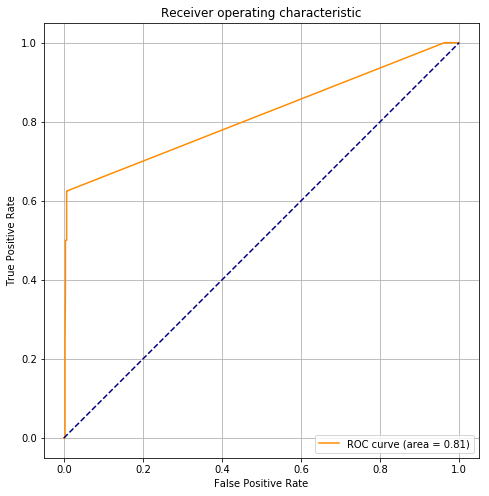

In [23]:
roc_auc = auc(fpr_values, tpr_values)
plt.figure(figsize=(8,8))
plt.plot(fpr_values, tpr_values, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()